# Dataset Patchify

> dataset will be patched here from whole side images

In [1]:
#| default_exp patch_dataset

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

In [26]:
#| export 
from fastcore.all import *
import cv2
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from patchify import patchify
from scipy import ndimage
import matplotlib as mpl
from typing import List, Tuple, Union, Optional

In [4]:
#| export
DPI=mpl.rcParams['figure.dpi']
mpl.rcParams['image.cmap'] = 'gray'

# Reading train images and masks from folder

Training and test image and mask can be downloaded from the following command
- `curl https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif > mask_name.tif`
- `curl https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif> train_images.tif`
- `curl https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing_groundtruth.tif> test_mask.tif`
- `curl https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing.tif> test_images.tif`

In [7]:
#| hide
root_path = Path.cwd().parent


Path('/home/hasan/workspace/git_data/fine_tune_SAM')

In [12]:
#| hide
data_path = Path(rf'{root_path}/data')
train_imgs = list(filter(lambda x: x.name=='training_images.tif', data_path.ls()))[0]
train_masks = list(filter(lambda x: x.name=='training_masks.tif', data_path.ls()))[0]
train_masks#


Path('/home/hasan/workspace/git_data/fine_tune_SAM/data/training_masks.tif')

In [13]:
#| hide
big_img = tifffile.imread(train_imgs)
big_msk = tifffile.imread(train_masks)
print(f' image tif has a shape and mask tif has a shape of {big_img.shape} and {big_msk.shape} respectively')

 image tif has a shape and mask tif has a shape of (165, 768, 1024) and (165, 768, 1024) respectively


# Testing image and masks 

2


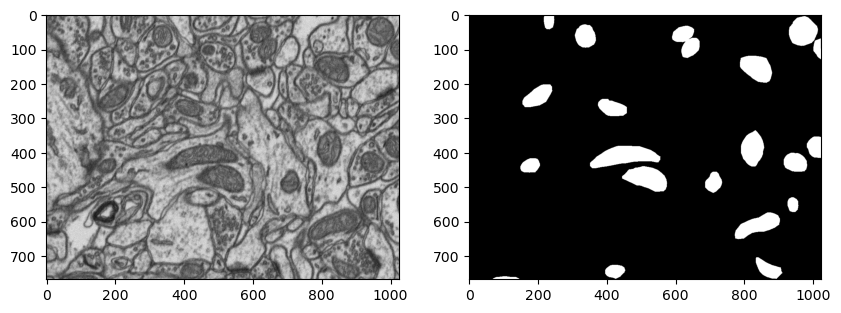

In [15]:
#| hide
idx = np.random.randint(0,big_img.shape[0])
print(idx)

fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(big_img[idx],cmap='gray')
ax[1].imshow(big_msk[idx],cmap='gray');

In [16]:
#| export
def show_rand_img(
        idx:int,  # in case of None, a random image is chosen
        im_path:str, 
        msk_path:str
        ):
    "Show random mask and image from together from path"
    images = Path(im_path).ls()
    masks = Path(msk_path).ls()


    if idx is None:
        idx = np.random.choice(len(images),1)[0]
    fig,ax = plt.subplots(1,2,figsize=(10,10))
    img = cv2.imread(str(images[idx]))
    msk = cv2.imread(str(masks[idx]))
    ax[0].imshow(img,cmap='gray')
    ax[1].imshow(msk,cmap='gray');

Notebook is [here](https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb)

# Saving the images in a single folder

- for this project this part is not necessary. 
- I am doing it so that we can use patchify in any projects
- Just tell where the full images are available, tell `patch size` and `step size` and it will created the patches with same name of the images, ony another index will be created to tell which patch number is that

In [17]:
#| hide
actual_im_path = Path(r'/home/hasan/workspace/data/microscopy_data/images')
actual_msk_path = Path(r'/home/hasan/workspace/data/microscopy_data/masks')
Path(actual_im_path).mkdir(exist_ok=True, parents=True)
Path(actual_msk_path).mkdir(exist_ok=True, parents=True)



In [18]:

for i in tqdm(range(len(big_img))):
    cv2.imwrite(f'{actual_im_path}/img_{i}.png', big_img[i])
    cv2.imwrite(f'{actual_msk_path}/img_{i}.png', big_msk[i])

100%|██████████| 165/165 [00:02<00:00, 61.58it/s]


In [19]:
#| hide
Path(actual_msk_path).ls()

(#165) [Path('/home/hasan/workspace/data/microscopy_data/masks/img_51.png'),Path('/home/hasan/workspace/data/microscopy_data/masks/img_98.png'),Path('/home/hasan/workspace/data/microscopy_data/masks/img_133.png'),Path('/home/hasan/workspace/data/microscopy_data/masks/img_107.png'),Path('/home/hasan/workspace/data/microscopy_data/masks/img_16.png'),Path('/home/hasan/workspace/data/microscopy_data/masks/img_150.png'),Path('/home/hasan/workspace/data/microscopy_data/masks/img_158.png'),Path('/home/hasan/workspace/data/microscopy_data/masks/img_145.png'),Path('/home/hasan/workspace/data/microscopy_data/masks/img_48.png'),Path('/home/hasan/workspace/data/microscopy_data/masks/img_40.png')...]

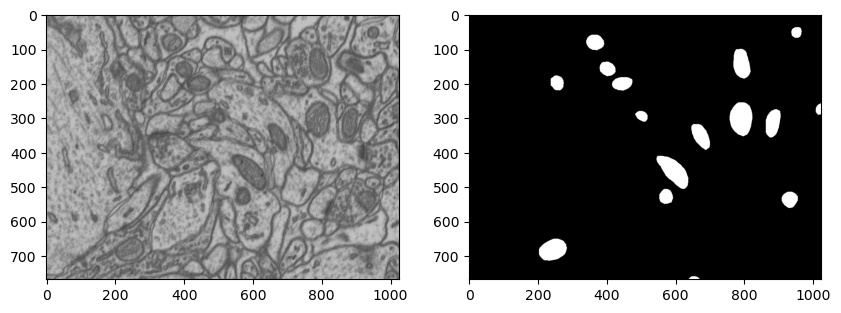

In [23]:
show_rand_img(idx=None, im_path=actual_im_path, msk_path=actual_msk_path)

# Creating patches from the folder

In [24]:
#| hide

patch_img_path=Path(r'/home/hasan/workspace/data/microscopy_data/patch_images')
patch_img_path.mkdir(exist_ok=True, parents=True)
patch_msk_path=Path(r'/home/hasan/workspace/data/microscopy_data/patch_masks')
patch_msk_path.mkdir(exist_ok=True, parents=True)

In [25]:
#| hide
PATCH_SIZE= 256
STEP = 256 # in case of overlap step will be less than patch size


In [27]:
#| export
def patch_img_and_mask(
        im_path:Union[Path, str],
        msk_path:Union[Path, str],
        patch_im_path:Union[Path, str],
        patch_msk_path:Union[Path, str],
        PATCH_SIZE:int=256,
        STEP:int=256,
        )->None:

    "Create patch images and masks from original images and masks"
    for i in tqdm(Path(im_path).ls()):
        name = Path(i).name
        msk_name = f'{msk_path}/{name}'
        img=cv2.imread(str(i), cv2.IMREAD_GRAYSCALE)
        msk = cv2.imread(msk_name, cv2.IMREAD_GRAYSCALE)

        #  patchify img and msks
        patch_img = patchify(img, PATCH_SIZE, STEP)
        patch_img = patch_img.reshape(-1, PATCH_SIZE, PATCH_SIZE)
        # saving patch images
        for patch_,img_ in enumerate(patch_img):
            cv2.imwrite(f'{patch_im_path}/{Path(name).stem}_p_{patch_}.png', img_)

        patch_msk = patchify(msk, PATCH_SIZE, STEP)
        patch_msk= patch_msk.reshape(-1, PATCH_SIZE, PATCH_SIZE)
        for patch_m,m in enumerate(patch_msk):
            cv2.imwrite(f'{patch_msk_path}/{Path(name).stem}_p_{patch_m}.png', m)
   



In [28]:
#| hide
patch_img_and_mask(
    im_path=actual_im_path,
    msk_path=actual_msk_path,
    patch_im_path=patch_img_path,
    patch_msk_path=patch_msk_path,
    PATCH_SIZE=PATCH_SIZE,
    STEP=STEP
)

100%|██████████| 165/165 [00:04<00:00, 35.80it/s]


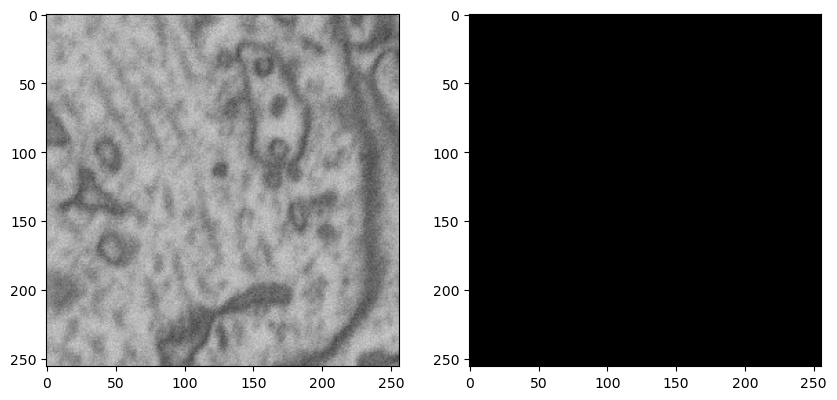

In [34]:
#| hide
show_rand_img(
    im_path=patch_img_path, 
    msk_path=patch_msk_path, 
    idx=None)

# delete patches with empty masks

- There is possible some patch has no mask, we want to delete those mask

In [35]:
for i in tqdm(patch_msk_path.ls()):
    name_ = Path(i).name
    img = cv2.imread(i.as_posix(), cv2.IMREAD_GRAYSCALE)
    if not img.max() > 0:
        i.unlink()
        im_ = Path(f'{patch_img_path}/{name_}')
        im_.unlink()

    

100%|██████████| 1980/1980 [00:00<00:00, 2697.89it/s]


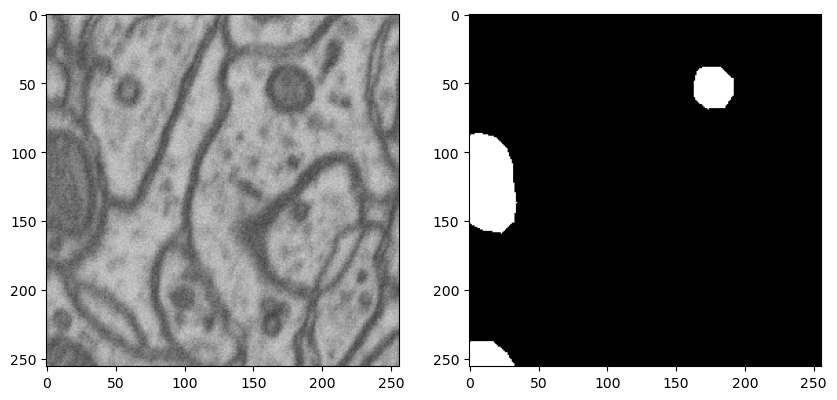

In [40]:
show_rand_img(
    im_path=patch_img_path, 
    msk_path=patch_msk_path, 
    idx=None)

- one can go further and check what is the percentage of mask, if mask has a defined percentage of pixels, then keep the patch, otherwise delete it
- but for me, right now i will further with modelling

In [43]:
import nbdev; nbdev.nbdev_export()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)